In [3]:
import re
import pandas as pd
from collections import defaultdict
import operator
from pprint import pprint
import os
import glob

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [14]:
path = "/home/aakankshaduggal/ai-ingest/datahub/ai/ingest/sentiment_analysis/EBC_data/"
files = [f for f in glob.glob(path + "Aetna 07_31_18.txt", recursive=True)]
print(files) 


['/home/aakankshaduggal/ai-ingest/datahub/ai/ingest/sentiment_analysis/EBC_data/Aetna 07_31_18.txt']


In [16]:

#Make a list
for i in range(len(files)):
    file = files[i]
    f = open(file,"r")
    if f.mode =="r":
        contents = f.read()
        print(contents)
    data = [contents.replace('\t','')]
# print(data[1])
# #Print the text of the files
# for file in files:
#     f = open(file,"r")
#     if f.mode =="r":
#       contents = f.read()
#       print(contents)

Customer/Partner Name:Briefing Date:  Tuesday7/31 (San Francisco)9-1 Need to figure out logistics and accessImportant Customer Background Information:Client Relationship, Red Hat Technology Update focusing on Container Technology, On premise Cloud, Infrastructure as Code and Automation.  Client has OCP, OpenStack and Anisible in Production today.Primary Focus for the Briefing:OpenStackOpenShift/CoreOS Futures,  Infrastructure as Code, AnsibleNext Gen Cloud Service Catalog managementNO CLOUDFORMSMain Product/Solutions wanting to discuss:Additional Notes:Reza Shafii (CoreOS)Briefing Date: Tuesday July 31st half-day 8:30 -1:00pmImportant Customer Background Information:Aetna is one of the largest health insurers in the US, also offers life and disability insurance, as well as retirement savings products. Its health care division offers HMO, PPO, point of service (POS), health savings account (HSA), and traditional indemnity coverage, along with dental, vision, behavioral health, and Medic

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


[['customer', 'partner', 'name', 'briefing', 'date', 'tuesday', 'san', 'francisco', 'need', 'to', 'figure', 'out', 'logistics', 'and', 'accessimportant', 'customer', 'background', 'information', 'client', 'relationship', 'red', 'hat', 'technology', 'update', 'focusing', 'on', 'container', 'technology', 'on', 'premise', 'cloud', 'infrastructure', 'as', 'code', 'and', 'automation', 'client', 'has', 'ocp', 'openstack', 'and', 'anisible', 'in', 'production', 'today', 'primary', 'focus', 'for', 'the', 'briefing', 'coreos', 'futures', 'infrastructure', 'as', 'code', 'ansiblenext', 'gen', 'cloud', 'service', 'catalog', 'managementno', 'cloudformsmain', 'product', 'solutions', 'wanting', 'to', 'discuss', 'additional', 'notes', 'reza', 'shafii', 'coreos', 'briefing', 'date', 'tuesday', 'july', 'st', 'half', 'day', 'pmimportant', 'customer', 'background', 'information', 'aetna', 'is', 'one', 'of', 'the', 'largest', 'health', 'insurers', 'in', 'the', 'us', 'also', 'offers', 'life', 'and', 'disabi

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['customer', 'partner', 'name', 'briefing', 'date', 'tuesday', 'san', 'francisco', 'need', 'to', 'figure', 'out', 'logistics', 'and', 'accessimportant', 'customer', 'background', 'information', 'client', 'relationship', 'red', 'hat', 'technology', 'update', 'focusing', 'on', 'container', 'technology', 'on', 'premise', 'cloud', 'infrastructure', 'as', 'code', 'and', 'automation', 'client', 'has', 'ocp', 'openstack', 'and', 'anisible', 'in', 'production', 'today', 'primary', 'focus', 'for', 'the', 'briefing', 'coreos', 'futures', 'infrastructure', 'as', 'code', 'ansiblenext', 'gen', 'cloud', 'service', 'catalog', 'managementno', 'cloudformsmain', 'product', 'solutions', 'wanting', 'to', 'discuss', 'additional', 'notes', 'reza', 'shafii', 'coreos', 'briefing', 'date', 'tuesday', 'july', 'st', 'half', 'day', 'pmimportant', 'customer', 'background', 'information', 'aetna', 'is', 'one', 'of', 'the', 'largest', 'health', 'insurers', 'in', 'the', 'us', 'also', 'offers', 'life', 'and', 'disabil

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])# if token.pos_ in allowed_postags])
    return texts_out


In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])



[['customer', 'partner', 'name', 'brief', 'date', 'tuesday', 'san', 'francisco', 'need', 'figure', 'logistic', 'accessimportant', 'customer', 'background', 'information', 'client', 'relationship', 'red', 'hat', 'technology', 'update', 'focus', 'container', 'technology', 'premise', 'cloud', 'infrastructure', 'code', 'automation', 'client', 'ocp', 'openstack', 'anisible', 'production', 'today', 'primary', 'focus', 'brief', 'coreos', 'future', 'infrastructure', 'code', 'ansiblenext', 'gen', 'cloud', 'service', 'catalog', 'managementno', 'cloudformsmain', 'product', 'solution', 'want', 'discuss', 'additional', 'note', 'reza', 'shafii', 'coreo', 'brief', 'date', 'tuesday', 'july', 'st', 'half', 'day', 'pmimportant', 'customer', 'background', 'information', 'aetna', 'one', 'large', 'health', 'insurer', '-PRON-', 'also', 'offer', 'life', 'disability', 'insurance', 'well', 'retirement', 'saving', 'product', 'health', 'care', 'division', 'offer', 'hmo', 'ppo', 'point', 'service', 'pos', 'health

In [21]:

print(data_lemmatized[0])

['customer', 'partner', 'name', 'brief', 'date', 'tuesday', 'san', 'francisco', 'need', 'figure', 'logistic', 'accessimportant', 'customer', 'background', 'information', 'client', 'relationship', 'red', 'hat', 'technology', 'update', 'focus', 'container', 'technology', 'premise', 'cloud', 'infrastructure', 'code', 'automation', 'client', 'ocp', 'openstack', 'anisible', 'production', 'today', 'primary', 'focus', 'brief', 'coreos', 'future', 'infrastructure', 'code', 'ansiblenext', 'gen', 'cloud', 'service', 'catalog', 'managementno', 'cloudformsmain', 'product', 'solution', 'want', 'discuss', 'additional', 'note', 'reza', 'shafii', 'coreo', 'brief', 'date', 'tuesday', 'july', 'st', 'half', 'day', 'pmimportant', 'customer', 'background', 'information', 'aetna', 'one', 'large', 'health', 'insurer', '-PRON-', 'also', 'offer', 'life', 'disability', 'insurance', 'well', 'retirement', 'saving', 'product', 'health', 'care', 'division', 'offer', 'hmo', 'ppo', 'point', 'service', 'pos', 'health'

In [22]:

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 3), (5, 1), (6, 1), (7, 2), (8, 1), (9, 2), (10, 2), (11, 1), (12, 1), (13, 4), (14, 1), (15, 2), (16, 1), (17, 4), (18, 3), (19, 1), (20, 3), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 4), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 2), (45, 6), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 3), (53, 3), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 2), (70, 2), (71, 1), (72, 2), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 2), (82, 3), (83, 2), (84, 2), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 2), (92, 1), (93, 2), (94, 1), (95, 2), (96, 1), (97, 4), (98, 1), (99, 2), (100, 1), (101, 2), (102, 2), (103, 1), (104, 2), (105, 1), (106, 1)]]


In [23]:

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('-PRON-', 1),
  ('accessimportant', 1),
  ('account', 1),
  ('additional', 2),
  ('aetna', 3),
  ('along', 1),
  ('also', 1),
  ('anisible', 2),
  ('ansiblenext', 1),
  ('automation', 2),
  ('background', 2),
  ('behavioral', 1),
  ('billion', 1),
  ('brief', 4),
  ('buy', 1),
  ('care', 2),
  ('catalog', 1),
  ('client', 4),
  ('cloud', 3),
  ('cloudformsmain', 1),
  ('code', 3),
  ('container', 2),
  ('coreo', 1),
  ('coreos', 1),
  ('cover', 1),
  ('coverage', 1),
  ('customer', 3),
  ('cvs', 1),
  ('date', 2),
  ('day', 1),
  ('deal', 1),
  ('dental', 1),
  ('disability', 1),
  ('discuss', 2),
  ('division', 1),
  ('figure', 1),
  ('focus', 4),
  ('francisco', 1),
  ('future', 1),
  ('gen', 1),
  ('giant', 1),
  ('group', 2),
  ('half', 1),
  ('hartford', 1),
  ('hat', 2),
  ('health', 6),
  ('history', 1),
  ('hmo', 1),
  ('hsa', 1),
  ('indemnity', 1),
  ('individual', 1),
  ('information', 2),
  ('infrastructure', 3),
  ('insurance', 3),
  ('insurer', 1),
  ('july', 1),
  ('l

In [24]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [25]:

# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]



[(0,
  '0.009*"health" + 0.009*"brief" + 0.009*"focus" + 0.009*"code" + '
  '0.009*"client" + 0.009*"technology" + 0.009*"product" + '
  '0.009*"infrastructure" + 0.009*"today" + 0.009*"insurance"'),
 (1,
  '0.010*"health" + 0.010*"cloud" + 0.010*"brief" + 0.010*"focus" + '
  '0.010*"update" + 0.010*"client" + 0.010*"infrastructure" + 0.010*"aetna" + '
  '0.010*"primary" + 0.010*"information"'),
 (2,
  '0.009*"partner" + 0.009*"plan" + 0.009*"offer" + 0.009*"one" + '
  '0.009*"openstack" + 0.009*"note" + 0.009*"pharmacy" + 0.009*"pos" + '
  '0.009*"point" + 0.009*"name"'),
 (3,
  '0.009*"partner" + 0.009*"plan" + 0.009*"offer" + 0.009*"one" + '
  '0.009*"openstack" + 0.009*"note" + 0.009*"pharmacy" + 0.009*"pos" + '
  '0.009*"point" + 0.009*"name"'),
 (4,
  '0.009*"health" + 0.009*"technology" + 0.009*"client" + 0.009*"brief" + '
  '0.009*"code" + 0.009*"focus" + 0.009*"infrastructure" + 0.009*"product" + '
  '0.009*"hat" + 0.009*"aetna"'),
 (5,
  '0.009*"partner" + 0.009*"plan" + 0.00

In [26]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -6.0654350483701345
Coherence Score:  0.46562501942595275


In [27]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)


/home/aakankshaduggal/env/lib64/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [27]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/home/aakankshaduggal/Downloads/mallet-2.0.8/bin/mallet'

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)



/home/aakankshaduggal/env/lib64/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [28]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('focus', 0.375),
   ('today', 0.25),
   ('giant', 0.125),
   ('note', 0.125),
   ('point', 0.125),
   ('pmimportant', 0.0),
   ('ocp', 0.0),
   ('offer', 0.0),
   ('one', 0.0),
   ('plan', 0.0)]),
 (1,
  [('cloud', 0.3333333333333333),
   ('medicare', 0.1111111111111111),
   ('hsa', 0.1111111111111111),
   ('shafii', 0.1111111111111111),
   ('client', 0.1111111111111111),
   ('sell', 0.1111111111111111),
   ('coverage', 0.1111111111111111),
   ('offer', 0.0),
   ('point', 0.0),
   ('pmimportant', 0.0)]),
 (2,
  [('hmo', 0.25),
   ('half', 0.25),
   ('future', 0.25),
   ('pos', 0.25),
   ('partner', 0.0),
   ('plan', 0.0),
   ('one', 0.0),
   ('openstack', 0.0),
   ('logistic', 0.0),
   ('pharmacy', 0.0)]),
 (3,
  [('infrastructure', 0.42857142857142855),
   ('coreo', 0.14285714285714285),
   ('cover', 0.14285714285714285),
   ('saving', 0.14285714285714285),
   ('catalog', 0.14285714285714285),
   ('partner', 0.0),
   ('pharmacy', 0.0),
   ('pos', 0.0),
   ('openstack', 0.0),


In [29]:


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



In [30]:


# Can take a long time to run.
limit=35; start=2; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)



Calculating 2-topic model
Calculating 3-topic model
Calculating 4-topic model
Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model


/home/aakankshaduggal/env/lib64/python3.7/site-packages/gensim/models/wrappers/ldamallet.py:380: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model


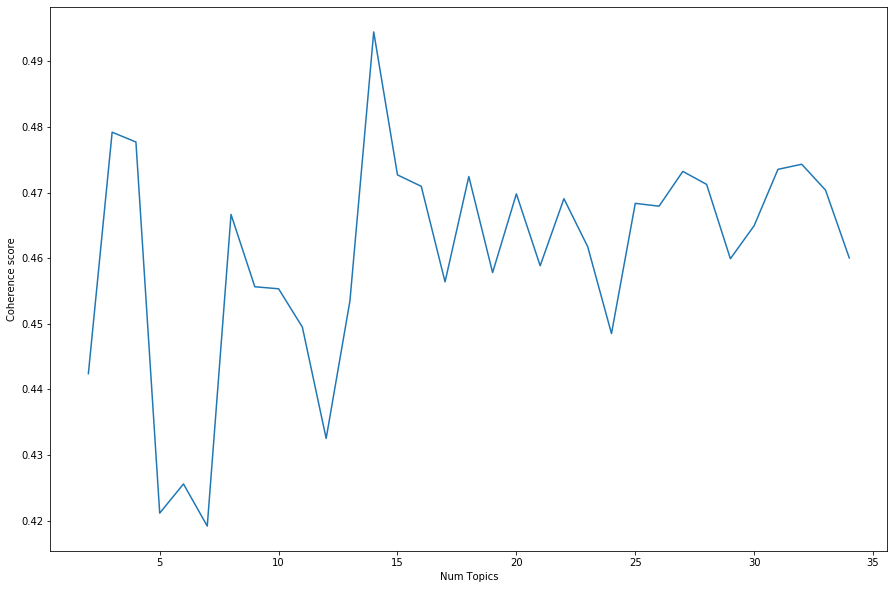

In [31]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()


In [32]:


# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))



Num Topics = 2  has Coherence Value of 0.442394
Num Topics = 3  has Coherence Value of 0.479195
Num Topics = 4  has Coherence Value of 0.4777
Num Topics = 5  has Coherence Value of 0.421133
Num Topics = 6  has Coherence Value of 0.42558
Num Topics = 7  has Coherence Value of 0.419157
Num Topics = 8  has Coherence Value of 0.466657
Num Topics = 9  has Coherence Value of 0.455637
Num Topics = 10  has Coherence Value of 0.455327
Num Topics = 11  has Coherence Value of 0.44948
Num Topics = 12  has Coherence Value of 0.432514
Num Topics = 13  has Coherence Value of 0.453484
Num Topics = 14  has Coherence Value of 0.494481
Num Topics = 15  has Coherence Value of 0.472685
Num Topics = 16  has Coherence Value of 0.470945
Num Topics = 17  has Coherence Value of 0.456381
Num Topics = 18  has Coherence Value of 0.472442
Num Topics = 19  has Coherence Value of 0.457794
Num Topics = 20  has Coherence Value of 0.469795
Num Topics = 21  has Coherence Value of 0.458836
Num Topics = 22  has Coherence V

In [33]:


# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 10
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))



[(0,
  '0.286*"additional" + 0.143*"coreo" + 0.143*"client" + 0.143*"cvs" + '
  '0.143*"behavioral" + 0.143*"member" + 0.000*"partner" + 0.000*"pharmacy" + '
  '0.000*"plan" + 0.000*"pmimportant"'),
 (1,
  '0.111*"premise" + 0.111*"discuss" + 0.111*"group" + 0.111*"today" + '
  '0.056*"hsa" + 0.056*"pmimportant" + 0.056*"plan" + 0.056*"main" + '
  '0.056*"hmo" + 0.056*"billion"'),
 (2,
  '0.176*"client" + 0.176*"insurance" + 0.118*"anisible" + 0.118*"solution" + '
  '0.059*"sell" + 0.059*"july" + 0.059*"reza" + 0.059*"medicare" + '
  '0.059*"dental" + 0.059*"day"'),
 (3,
  '0.250*"information" + 0.250*"offer" + 0.250*"note" + 0.125*"coverage" + '
  '0.125*"hartford" + 0.000*"partner" + 0.000*"one" + 0.000*"openstack" + '
  '0.000*"pharmacy" + 0.000*"point"'),
 (4,
  '0.250*"customer" + 0.167*"tuesday" + 0.167*"date" + 0.167*"primary" + '
  '0.083*"retirement" + 0.083*"half" + 0.083*"vision" + 0.000*"partner" + '
  '0.000*"plan" + 0.000*"pmimportant"'),
 (5,
  '0.286*"focus" + 0.143*"re

In [34]:
optimal_model.show_topic(0,10)

[('additional', 0.2857142857142857),
 ('coreo', 0.14285714285714285),
 ('client', 0.14285714285714285),
 ('cvs', 0.14285714285714285),
 ('behavioral', 0.14285714285714285),
 ('member', 0.14285714285714285),
 ('partner', 0.0),
 ('pharmacy', 0.0),
 ('plan', 0.0),
 ('pmimportant', 0.0)]

In [35]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['additional', 'coreo', 'client', 'cvs', 'behavioral', 'member', 'partner', 'pharmacy', 'plan', 'pmimportant']
Topic 1: ['premise', 'discuss', 'group', 'today', 'hsa', 'pmimportant', 'plan', 'main', 'hmo', 'billion']
Topic 2: ['client', 'insurance', 'anisible', 'solution', 'sell', 'july', 'reza', 'medicare', 'dental', 'day']
Topic 3: ['information', 'offer', 'note', 'coverage', 'hartford', 'partner', 'one', 'openstack', 'pharmacy', 'point']
Topic 4: ['customer', 'tuesday', 'date', 'primary', 'retirement', 'half', 'vision', 'partner', 'plan', 'pmimportant']
Topic 5: ['focus', 'red', 'san', 'shafii', 'technology', 'catalog', 'pharmacy', '-PRON-', 'individual', 'infrastructure']
Topic 6: ['relationship', 'infrastructure', 'indemnity', 'text', 'deal', 'st', 'insurer', 'update', 'partner', 'offer']
Topic 7: ['health', 'saving', 'segment', 'large', 'million', 'buy', 'division', 'gen', 'point', 'ansiblenext']
Topic 8: ['code', 'background', 'production', 'automation', 'medicaid', 'fu

In [36]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.107,"premise, discuss, group, today, hsa, pmimporta...",Customer/Partner Name:Briefing Date: Tuesday7...


In [37]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0, 1])]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.107,"premise, discuss, group, today, hsa, pmimporta...",Customer/Partner Name:Briefing Date: Tuesday7...


In [38]:
[text.split() for text in df_dominant_topic['Keywords'].tolist()]

[['premise,',
  'discuss,',
  'group,',
  'today,',
  'hsa,',
  'pmimportant,',
  'plan,',
  'main,',
  'hmo,',
  'billion']]

In [39]:


for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))



0. Dominant keywords: ['premise', 'discuss', 'group', 'today', 'hsa']


In [40]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.107,"premise, discuss, group, today, hsa, pmimporta...",Customer/Partner Name:Briefing Date: Tuesday7...


In [41]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 1
Keywords: premise, discuss, group, today, hsa, pmimportant, plan, main, hmo, billion

Customer/Partner Name:Briefing Date:  Tuesday7/31 (San Francisco)9-1 Need to figure out logistics and accessImportant Customer Background Information:Client Relationship, Red Hat Technology Update focusing on Container Technology, On premise Cloud, Infrastructure as Code and Automation.  Client has OCP, OpenStack and Anisible in Production today.Primary Focus for the Briefing:OpenStackOpenShift/CoreOS Futures,  Infrastructure as Code, AnsibleNext Gen Cloud Service Catalog managementNO CLOUDFORMSMain Product/Solutions wanting to discuss:Additional Notes:Reza Shafii (CoreOS)Briefing Date: Tuesday July 31st half-day 8:30 -1:00pmImportant Customer Background Information:Aetna is one of the largest health insurers in the US, also offers life and disability insurance, as well as retirement savings products. Its health care division offers HMO, PPO, point of service (POS), health savings accou

In [42]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,1.0,"premise, discuss, group, today, hsa, pmimporta...",NaN,NaN
1.0,NaN,NaN,1.0,1.0


In [43]:


with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)



,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0.0,1.0,"premise, discuss, group, today, hsa, pmimportant, plan, main, hmo, billion",NaN,NaN
1.0,NaN,NaN,1.0,1.0


In [44]:
df_dominant_topics.to_csv('df_dominant_topics.csv', index=False)